In [1]:
import os
os.chdir('C:/Users/clack/Projects/nwm')

import torch
import torchvision
import torchvision.transforms as transforms
from typing import Callable


transform = transforms.Compose([
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
def denormalize(tensor, mean=0.5, std=0.5):
    return tensor * std + mean

class OnDemandDataset(torchvision.datasets.VisionDataset):
  def __init__(self, size: int, sample: Callable[[], torch.Tensor], transform = None):
    super().__init__(transform=transform)
    self.size = size
    self.sample = sample

  def __len__(self):
    return self.size
  
  def __getitem__(self, _) -> torch.Tensor:
    return self.transform(self.sample()) if self.transform else self.sample()
  
from experiment.nav2d import Topo

def sample_image():
  return torch.from_numpy(
    Topo.random().render(camera_size=64)
  ).permute(2, 0, 1).to(torch.float32)

def nav2d_dataset(size: int):
  return OnDemandDataset(
    size=size,
    sample=sample_image,
    transform=transform
  )
trainloader = torch.utils.data.DataLoader(nav2d_dataset(1000), batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(nav2d_dataset(1000), batch_size=16, shuffle=False)

In [24]:
import glob
import json
import os
from pathlib import Path
import numpy as np
from tqdm import tqdm

from experiment.vae import make_vae

SAVE_DIR = Path('checkpoints/vae/topo')
RESUME = True

device = 'cuda'
vae = make_vae().to(device)

# os.makedirs(SAVE_DIR, exist_ok=True)
latest_checkpoint_number = max([
  int(Path(path).name[len('check'):][:-len('.pt')]) for path in glob.glob('*.pt', root_dir=SAVE_DIR)
], default=-1)
if latest_checkpoint_number >= 0:
  print(f'Resuming and starting epoch {latest_checkpoint_number + 1}.')
  vae.load_state_dict(torch.load(SAVE_DIR / f'check{latest_checkpoint_number}.pt'))
  with open(SAVE_DIR / f'stats{latest_checkpoint_number}.json', 'r') as f:
    train_stats = json.load(f)
  raw_loss_log = train_stats['raw_loss_log']
  weighted_loss_log = train_stats['weighted_loss_log']
  samples = train_stats['samples']
  epoch = latest_checkpoint_number + 1
else:
  raw_loss_log = []
  weighted_loss_log = []
  samples = 0
  epoch = 0

optimizer = torch.optim.Adam(params=vae.parameters(), lr=3e-6)
while epoch < 60:
  # blur = max(0, 1 - samples / (16000))
  # trainloader.dataset.transform = transforms.Compose([
  #   transforms.Normalize((0.5,), (0.5,))
  # ]) if blur == 0 else transforms.Compose([
  #   transforms.Normalize((0.5,), (0.5,)),
  #   transforms.GaussianBlur(5, blur),
  #   transforms.GaussianBlur(5, blur),
  # ])
  for images in tqdm(trainloader, desc=f'Epoch {epoch}'):
    # if since_last_loss_log == log_loss_every:
    #   assert loss_accumulator is not None
    #   loss_log.append(sum(loss_accumulator, start=np.zeros(2)) / len(loss_accumulator))
    #   loss_accumulator = []
    #   since_last_loss_log = 0
    loss_weight = torch.tensor([3.0, 0.01], device=device)

    images = images.to(device)
    raw_losses = vae.training_step(images)
    weighted_losses = loss_weight * torch.stack(raw_losses)
    total_loss = weighted_losses.sum()

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    raw_loss_log.append([loss.detach().cpu().item() / images.shape[0] for loss in raw_losses])
    weighted_loss_log.append([loss.detach().cpu().item() / images.shape[0] for loss in weighted_losses])
    samples += images.shape[0]
  print(f'Epoch end loss: {raw_loss_log[-1]}')
  train_stats = {
    'raw_loss_log': raw_loss_log,
    'weighted_loss_log': weighted_loss_log,
    'samples': samples
  }
  with open(SAVE_DIR / f'stats{epoch}.json', 'w') as f:
    json.dump(train_stats, f, indent=2)
  raw_loss_log = []
  weighted_loss_log = []
  torch.save(vae.state_dict(), SAVE_DIR / f'check{epoch}.pt')
  epoch += 1

Resuming and starting epoch 57.


Epoch 57: 100%|██████████| 63/63 [00:29<00:00,  2.15it/s]


Epoch end loss: [386.6038818359375, 2029.134033203125]


Epoch 58: 100%|██████████| 63/63 [00:28<00:00,  2.18it/s]


Epoch end loss: [351.19927978515625, 2043.86865234375]


Epoch 59: 100%|██████████| 63/63 [00:28<00:00,  2.19it/s]

Epoch end loss: [356.7497253417969, 2047.0416259765625]


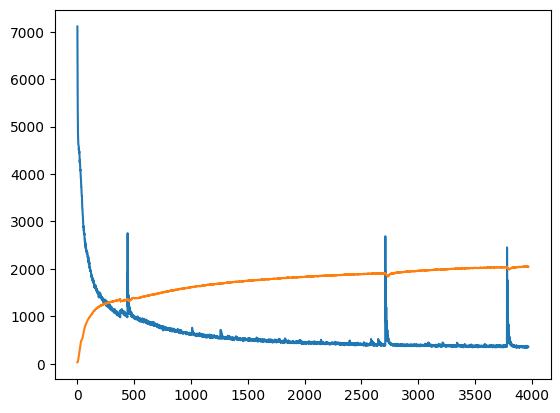

7113.4384765625 356.7497253417969
lr 3e-4, 0.1lpips: 9192.9423828125 4540.0302734375
lr 1e-4, 0.1lpips: 8918.8046875 1402.575927734375
lr 3e-5, 0.1lpips: 9193.6279296875 1534.5819091796875
lr 1e-4, 0.2lpips: 9000.794921875 1412.0052490234375


In [25]:
import glob
import json
from pathlib import Path
import matplotlib.pyplot as plt

# raw_losses = raw_loss_log
SAVE_DIR = Path('checkpoints/vae/topo')
latest_checkpoint_number = max([
  int(Path(path).name[len('check'):][:-len('.pt')]) for path in glob.glob('*.pt', root_dir=SAVE_DIR)
], default=-1)
raw_losses = []
for checkpoint_number in range(latest_checkpoint_number + 1):
  with open(SAVE_DIR / f'stats{checkpoint_number}.json', 'r') as f:
    train_stats = json.load(f)
  raw_losses.extend(train_stats['raw_loss_log'])

plt.plot([v[0] for v in raw_losses])
plt.plot([v[1] for v in raw_losses])
plt.show()
print(raw_losses[0][0], raw_losses[-1][0])
print('lr 3e-4, 0.1lpips: 9192.9423828125 4540.0302734375')
print('lr 1e-4, 0.1lpips: 8918.8046875 1402.575927734375')
print('lr 3e-5, 0.1lpips: 9193.6279296875 1534.5819091796875')
print('lr 1e-4, 0.2lpips: 9000.794921875 1412.0052490234375')

Encoding took 0.6574759000004633s.


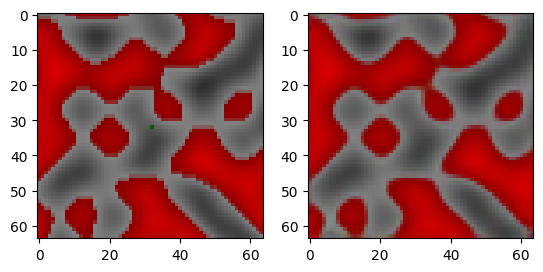

In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt

from experiment.vae import make_vae

# original_image = trainset[4][0].unsqueeze(0)
# load_vae = vae
device = 'cuda'
load_vae = make_vae().to('cuda')
load_vae.load_state_dict(torch.load('checkpoints/vae/topo/check59.pt'))
testset = nav2d_dataset(1)
testset.transform = transforms.Compose([
  transforms.Normalize((0.5,), (0.5,)),
  # transforms.GaussianBlur(5, 1.0),
  # transforms.GaussianBlur(5, 1.0),
])
original_image = testset[0].unsqueeze(0).to(device)
start_time = time.perf_counter()
load_vae.encode(original_image)
encoding_time = time.perf_counter() - start_time
print(f'Encoding took {encoding_time}s.')
with torch.no_grad():
  reconstructed_image = load_vae.forward_recons(original_image).cpu().numpy().squeeze(0).transpose(1, 2, 0)
fig, axes = plt.subplots(1, 2)
axes[0].imshow(denormalize(original_image).cpu().numpy().squeeze(0).transpose(1, 2, 0))
axes[1].imshow(denormalize(reconstructed_image))

In [6]:
@torch.no_grad()
def convert_checkpoint(path: str):
  device = 'cuda'
  v = make_vae().to(device)
  v.load_state_dict(torch.load(path))

  latents = []
  for images in trainloader:
    images = images.to(device)
    z = v.encode(images)
    latents.append(z)

  std = torch.cat(latents).std()
  print(std)
  # v.latent_scaling_factor = nn.Buffer(torch.ones(1, device=device) / std)
  # torch.save(v.state_dict(), path)

convert_checkpoint('checkpoints/vae/topo/check59.pt')

tensor(2.3777, device='cuda:0')


Encoding took 0.021984799997881055s.


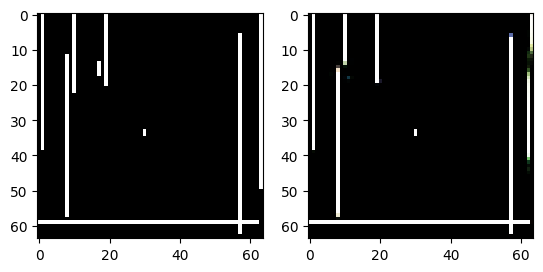

In [17]:
import time
import numpy as np
import matplotlib.pyplot as plt

# original_image = trainset[4][0].unsqueeze(0)
# load_vae = vae
device = 'cuda'
load_vae = make_vae().to('cuda')
load_vae.load_state_dict(torch.load('../checkpoints/vae/check57.pt'))
testset = nav2d_dataset(1)
testset.transform = transforms.Compose([
  transforms.Normalize((0.5,), (0.5,)),
  # transforms.GaussianBlur(5, 1.0),
  # transforms.GaussianBlur(5, 1.0),
])
original_image = testset[0].unsqueeze(0).to(device)
start_time = time.perf_counter()
load_vae.encode(original_image)
encoding_time = time.perf_counter() - start_time
print(f'Encoding took {encoding_time}s.')
with torch.no_grad():
  reconstructed_image = load_vae.forward_recons(original_image).cpu().numpy().squeeze(0).transpose(1, 2, 0)
fig, axes = plt.subplots(1, 2)
axes[0].imshow(denormalize(original_image).cpu().numpy().squeeze(0).transpose(1, 2, 0))
axes[1].imshow(denormalize(reconstructed_image))